## Import the Required Libraries and Data

In [77]:
# Import modules
%matplotlib inline

import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier 
from urllib.request import urlopen 

plt.style.use('ggplot')
pd.set_option('display.max_columns', 500) 

In [78]:
breast_cancer = pd.read_csv('BreastTissue.csv')

# names = ['id', 'diagnosis', 'radius_mean', 
#          'texture_mean', 'perimeter_mean', 'area_mean', 
#          'smoothness_mean', 'compactness_mean', 
#          'concavity_mean','concave_points_mean', 
#          'symmetry_mean', 'fractal_dimension_mean',
#          'radius_se', 'texture_se', 'perimeter_se', 
#          'area_se', 'smoothness_se', 'compactness_se', 
#          'concavity_se', 'concave_points_se', 
#          'symmetry_se', 'fractal_dimension_se', 
#          'radius_worst', 'texture_worst', 
#          'perimeter_worst', 'area_worst', 
#          'smoothness_worst', 'compactness_worst', 
#          'concavity_worst', 'concave_points_worst', 
#          'symmetry_worst', 'fractal_dimension_worst'] 

dx = ['car','fad','mas','gla','con','adi']

In [79]:
breast_cancer.head()

,Case #,I0,PA500,HFS,DA,Area,A/DA,Max IP,DR,P,Class
0,1,524.794072,0.187448,0.032114,228.800228,6843.598481,29.910803,60.204880,220.737212,556.828334,car
1,2,330.000000,0.226893,0.265290,121.154201,3163.239472,26.109202,69.717361,99.084964,400.225776,car
2,3,551.879287,0.232478,0.063530,264.804935,11888.391830,44.894903,77.793297,253.785300,656.769449,car
3,4,380.000000,0.240855,0.286234,137.640111,5402.171180,39.248524,88.758446,105.198568,493.701814,car
4,5,362.831266,0.200713,0.244346,124.912559,3290.462446,26.342127,69.389389,103.866552,424.796503,car


In [80]:
# Setting 'id_number' as our index
breast_cancer.set_index(['Case #'], inplace = True)  # inplace = True indicates that the changes made will be made direcly to the 
# given dataset instead of creating a copy

# Converted to binary
breast_cancer['Class'] = breast_cancer['Class'].map({'car':1,'fad':2,'mas':3,'gla':4,'con':5,'adi':6})

## Missing Value checks and Data Cleaning

In [81]:
breast_cancer.apply(lambda x: x.isnull().sum())

I0        0
PA500     0
HFS       0
DA        0
Area      0
A/DA      0
Max IP    0
DR        0
P         0
Class     0
dtype: int64

In [82]:
names = breast_cancer.columns

In [83]:
# For later use in CART models
names_index = names[1:]
#names_index = names_index[:-1]
print(names_index)

Index(['PA500', 'HFS', 'DA', 'Area', 'A/DA', 'Max IP', 'DR', 'P', 'Class'], dtype='object')


In [84]:
breast_cancer.head()

,I0,PA500,HFS,DA,Area,A/DA,Max IP,DR,P,Class
Case #,,,,,,,,,,
1,524.794072,0.187448,0.032114,228.800228,6843.598481,29.910803,60.204880,220.737212,556.828334,1
2,330.000000,0.226893,0.265290,121.154201,3163.239472,26.109202,69.717361,99.084964,400.225776,1
3,551.879287,0.232478,0.063530,264.804935,11888.391830,44.894903,77.793297,253.785300,656.769449,1
4,380.000000,0.240855,0.286234,137.640111,5402.171180,39.248524,88.758446,105.198568,493.701814,1
5,362.831266,0.200713,0.244346,124.912559,3290.462446,26.342127,69.389389,103.866552,424.796503,1


In [85]:
print("Here's the dimensions of our data frame:\n", breast_cancer.shape)
print("Here's the data types of our columns:\n",breast_cancer.dtypes)

Here's the dimensions of our data frame:
 (106, 10)
Here's the data types of our columns:
 I0        float64
PA500     float64
HFS       float64
DA        float64
Area      float64
A/DA      float64
Max IP    float64
DR        float64
P         float64
Class       int64
dtype: object


In [86]:
breast_cancer.describe()

,I0,PA500,HFS,DA,Area,A/DA,Max IP,DR,P,Class
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000
mean,784.251618,0.120133,0.114691,190.568642,7335.155161,23.473784,75.381258,166.710575,810.638127,3.500000
std,753.950075,0.068596,0.101347,190.801448,18580.314212,23.354672,81.345838,181.309580,763.019135,1.806074
min,103.000000,0.012392,-0.066323,19.647670,70.426239,1.595742,7.968783,-9.257696,124.978561,1.000000
25%,250.000000,0.067413,0.043982,53.845470,409.647141,8.180321,26.893773,41.781258,270.215238,2.000000
50%,384.936489,0.105418,0.086568,120.777303,2219.581163,16.133657,44.216040,97.832557,454.108153,3.000000
75%,1487.989626,0.169602,0.166504,255.334809,7615.204968,30.953294,83.671755,232.990070,1301.559438,5.000000
max,2800.000000,0.358316,0.467748,1063.441427,174480.476200,164.071543,436.099640,977.552367,2896.582483,6.000000


## Split the Dataset for Training & Testing

In [87]:
feature_space = breast_cancer.iloc[:, breast_cancer.columns != 'Class']
feature_class = breast_cancer.iloc[:, breast_cancer.columns == 'Class']


training_set, test_set, class_set, test_class_set = train_test_split(feature_space,
                                                                    feature_class,
                                                                    test_size = 0.20, 
                                                                    random_state = 42)

In [88]:
# Cleaning test sets to avoid future warning messages
class_set = class_set.values.ravel() 
test_class_set = test_class_set.values.ravel() 

## Random Forest Classifier

In [89]:
# Set the random state for reproducibility
fit_rf = RandomForestClassifier(random_state=42)

## Hyper-Parameter Optimization using GridSearchCV

In [90]:
np.random.seed(42)
start = time.time()

param_dist = {'max_depth': [2, 3, 4],
              'bootstrap': [True, False],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'criterion': ['gini', 'entropy']}

cv_rf = GridSearchCV(fit_rf, cv = 10,
                     param_grid=param_dist, 
                     n_jobs = 3)

cv_rf.fit(training_set, class_set)
print('Best Parameters using grid search: \n', cv_rf.best_params_)
end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))

Best Parameters using grid search: 
 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto'}
Time taken in grid search:  20.08


In [91]:
# Set best parameters given by grid search 
fit_rf.set_params(criterion = 'gini',
                  max_features = 'auto', 
                  max_depth = 4)

RandomForestClassifier(max_depth=4, random_state=42)

## OOB Rate

In [92]:
# fit_rf.set_params(warm_start=True, 
#                   oob_score=True)

# min_estimators = 15
# max_estimators = 1000

# error_rate = {}

# for i in range(min_estimators, max_estimators + 1):
#     fit_rf.set_params(n_estimators=i)
#     fit_rf.fit(training_set, class_set)

#     oob_error = 1 - fit_rf.oob_score_
#     error_rate[i] = oob_error

In [93]:
# # Convert dictionary to a pandas series for easy plotting 
# oob_series = pd.Series(error_rate)

In [94]:
# fig, ax = plt.subplots(figsize=(10, 10))

# ax.set_facecolor('#fafafa')

# oob_series.plot(kind='line',color = 'red')
# plt.axhline(0.055, color='#875FDB',linestyle='--')
# plt.axhline(0.05, color='#875FDB',linestyle='--')
# plt.xlabel('n_estimators')
# plt.ylabel('OOB Error Rate')
# plt.title('OOB Error Rate Across various Forest sizes \n(From 15 to 1000 trees)')

In [95]:
#print('OOB Error rate for 400 trees is: {0:.5f}'.format(oob_series[400]))

In [96]:
# Refine the tree via OOB Output 
# warm start - it gives your model the power to reuse the older fitted params
#fit_rf.set_params(n_estimators=400,
#                  bootstrap = True,
#                  warm_start=False, 
#                  oob_score=False)

# Train the RandomForest

In [97]:
fit_rf.fit(training_set, class_set)

RandomForestClassifier(max_depth=4, random_state=42)

## Variable Importance

In [98]:
def variable_importance(fit):
    """
    Purpose
    ----------
    Checks if model is fitted CART model then produces variable importance
    and respective indices in dictionary.

    Parameters
    ----------
    * fit:  Fitted model containing the attribute feature_importances_

    Returns
    ----------
    Dictionary containing arrays with importance score and index of columns
    ordered in descending order of importance.
    """
    try:
        if not hasattr(fit, 'fit'):
            return print("'{0}' is not an instantiated model from scikit-learn".format(fit)) 

        # Captures whether the model has been trained
        if not vars(fit)["estimators_"]:
            return print("Model does not appear to be trained.")
    except KeyError:
        print("Model entered does not contain 'estimators_' attribute.")

    importances = fit.feature_importances_
    indices = np.argsort(importances)[::-1]
    return {'importance': importances,
            'index': indices}

In [99]:
var_imp_rf = variable_importance(fit_rf)

importances_rf = var_imp_rf['importance']

indices_rf = var_imp_rf['index']

In [100]:
def print_var_importance(importance, indices, name_index):
    """
    Purpose
    ----------
    Prints dependent variable names ordered from largest to smallest
    based on information gain for CART model.
    Parameters
    ----------
    * importance: Array returned from feature_importances_ for CART
                models organized by dataframe index
    * indices: Organized index of dataframe from largest to smallest
                based on feature_importances_
    * name_index: Name of columns included in model

    Returns
    ----------
    Prints feature importance in descending order
    """
    print("Feature ranking:")

    for f in range(0, indices.shape[0]):
        i = f
        print("{0}. The feature '{1}' has a Mean Decrease in Impurity of {2:.5f}"
              .format(f + 1,
                      names_index[indices[i]],
                      importance[indices[f]]))

In [101]:
print_var_importance(importances_rf, indices_rf, names_index)

Feature ranking:
1. The feature 'PA500' has a Mean Decrease in Impurity of 0.21960
2. The feature 'Class' has a Mean Decrease in Impurity of 0.19843
3. The feature 'HFS' has a Mean Decrease in Impurity of 0.11338
4. The feature 'DR' has a Mean Decrease in Impurity of 0.11318
5. The feature 'Area' has a Mean Decrease in Impurity of 0.10963
6. The feature 'A/DA' has a Mean Decrease in Impurity of 0.07643
7. The feature 'Max IP' has a Mean Decrease in Impurity of 0.06696
8. The feature 'P' has a Mean Decrease in Impurity of 0.06438
9. The feature 'DA' has a Mean Decrease in Impurity of 0.03801


## Predictions

In [102]:
predictions_rf = fit_rf.predict(test_set)

## Confusion Matrix

In [103]:
def create_conf_mat(test_class_set, predictions):
    """Function returns confusion matrix comparing two arrays"""
    if (len(test_class_set.shape) != len(predictions.shape) == 1):
        return print('Arrays entered are not 1-D.\nPlease enter the correctly sized sets.')
    elif (test_class_set.shape != predictions.shape):
        return print('Number of values inside the Arrays are not equal to each other.\nPlease make sure the array has the same number of instances.')
    else:
        # Set Metrics
        test_crosstb_comp = pd.crosstab(index = test_class_set,
                                        columns = predictions)
        # Changed for Future deprecation of as_matrix
        test_crosstb = test_crosstb_comp.values
        return test_crosstb

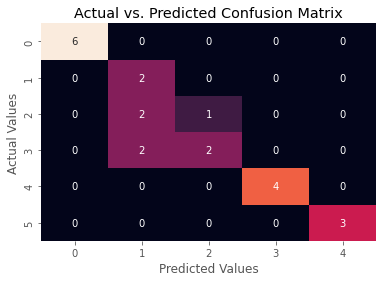

In [104]:
conf_mat = create_conf_mat(test_class_set, predictions_rf)
sns.heatmap(conf_mat, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs. Predicted Confusion Matrix')
plt.show()

## Accuracy

In [105]:
accuracy_rf = fit_rf.score(test_set, test_class_set)

print("Here is our accuracy on the test set:\n {0:.3f}"\
      .format(accuracy_rf))

Here is our accuracy on the test set:
 0.773


## Error Rate

In [106]:
# Here we calculate the test error rate!
test_error_rate_rf = 1 - accuracy_rf
print("The test error rate for our model is:\n {0: .4f}"\
      .format(test_error_rate_rf))

The test error rate for our model is:
  0.2273


## Area Under Curve (AUC)

In [107]:
# We grab the second array from the output which corresponds to
# to the predicted probabilites of positive classes 
# Ordered wrt fit.classes_ in our case [0, 1] where 1 is our positive class
predictions_prob = fit_rf.predict_proba(test_set)[:, 1]

fpr2, tpr2, _ = roc_curve(test_class_set,
                          predictions_prob,
                          pos_label = 1)

In [108]:
auc_rf = auc(fpr2, tpr2)

In [109]:
def plot_roc_curve(fpr, tpr, auc, estimator, xlim=None, ylim=None):
    """
    Purpose
    ----------
    Function creates ROC Curve for respective model given selected parameters.
    Optional x and y limits to zoom into graph

    Parameters
    ----------
    * fpr: Array returned from sklearn.metrics.roc_curve for increasing
            false positive rates
    * tpr: Array returned from sklearn.metrics.roc_curve for increasing
            true positive rates
    * auc: Float returned from sklearn.metrics.auc (Area under Curve)
    * estimator: String represenation of appropriate model, can only contain the
    following: ['knn', 'rf', 'nn']
    * xlim: Set upper and lower x-limits
    * ylim: Set upper and lower y-limits
    """
    my_estimators = {'knn': ['Kth Nearest Neighbor', 'deeppink'],
              'rf': ['Random Forest', 'red'],
              'nn': ['Neural Network', 'purple']}

    try:
        plot_title = my_estimators[estimator][0]
        color_value = my_estimators[estimator][1]
    except KeyError as e:
        print("'{0}' does not correspond with the appropriate key inside the estimators dictionary. \
\nPlease refer to function to check `my_estimators` dictionary.".format(estimator))
        raise

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor('#fafafa')

    plt.plot(fpr, tpr,
             color=color_value,
             linewidth=1)
    plt.title('ROC Curve For {0} (AUC = {1: 0.3f})'\
              .format(plot_title, auc))

    plt.plot([0, 1], [0, 1], 'k--', lw=2) # Add Diagonal line
    plt.plot([0, 0], [1, 0], 'k--', lw=2, color = 'black')
    plt.plot([1, 0], [1, 1], 'k--', lw=2, color = 'black')
    if xlim is not None:
        plt.xlim(*xlim)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    plt.close()

C:\Users\nisarg negi\AppData\Local\Temp\ipykernel_17844\2153116955.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 0], [1, 0], 'k--', lw=2, color = 'black')
C:\Users\nisarg negi\AppData\Local\Temp\ipykernel_17844\2153116955.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([1, 0], [1, 1], 'k--', lw=2, color = 'black')


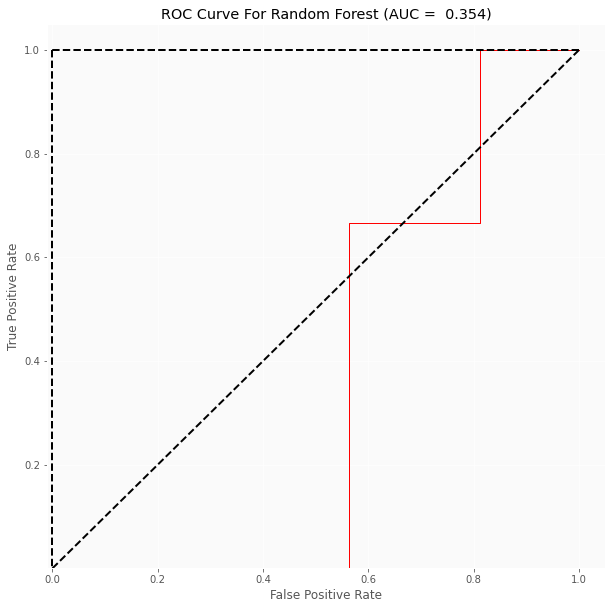

In [110]:
plot_roc_curve(fpr2, tpr2, auc_rf, 'rf',
               xlim=(-0.01, 1.05), 
               ylim=(0.001, 1.05))

## Classification Report

In [111]:
def print_class_report(predictions, alg_name):
    """
    Purpose
    ----------
    Function helps automate the report generated by the
    sklearn package. Useful for multiple model comparison

    Parameters:
    ----------
    predictions: The predictions made by the algorithm used
    alg_name: String containing the name of the algorithm used
    
    Returns:
    ----------
    Returns classification report generated from sklearn. 
    """
    print('Classification Report for {0}:'.format(alg_name))
    print(classification_report(predictions, 
            test_class_set, 
            target_names = dx))

In [112]:
class_report = print_class_report(predictions_rf, 'Random Forest')

Classification Report for Random Forest:
              precision    recall  f1-score   support

         car       1.00      1.00      1.00         6
         fad       0.00      0.00      0.00         0
         mas       0.67      0.33      0.44         6
         gla       0.50      0.67      0.57         3
         con       1.00      1.00      1.00         4
         adi       1.00      1.00      1.00         3

    accuracy                           0.77        22
   macro avg       0.69      0.67      0.67        22
weighted avg       0.84      0.77      0.79        22



C:\Software\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Software\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Software\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
